In [ ]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Data/train'
val_path = '/content/drive/MyDrive/Data/valid'
test_path = '/content/drive/MyDrive/Data/test'

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'large.cell.carcinoma': 51, 'adenocarcinoma': 120}


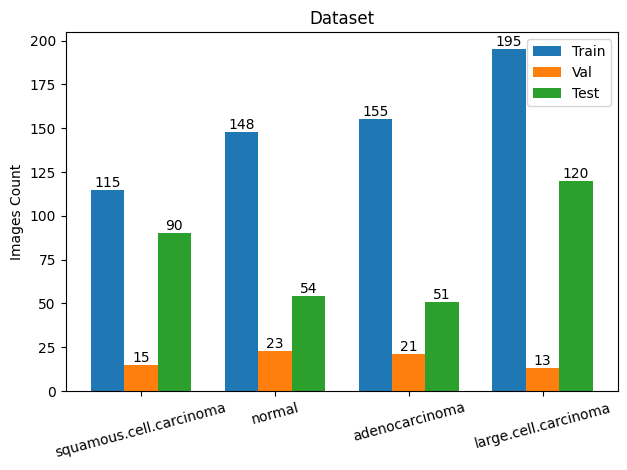

In [ ]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [ ]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [ ]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3),
                         include_top = False,
                         weights = 'imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [ ]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

call_back = [mc,early_stopping];

In [ ]:
# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64]

best_accuracy = 0
best_hyperparameters = {}

# Hyperparameter tuning loop
for lr in learning_rates:
    for batch_size in batch_sizes:
          # Fitting and training the Model
          incep = model_incep.fit(
                  train_data,
                  steps_per_epoch = train_data.samples//train_data.batch_size,
                  epochs = 32,
                  validation_data = val_data,
                  validation_steps = val_data.samples//val_data.batch_size,
                  callbacks = call_back
                 )
        _, accuracy = model.evaluate(test_data)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 6.5750 - accuracy: 0.4474
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 542s 4s/step - loss: 6.5750 - accuracy: 0.4474 - val_loss: 2.8322 - val_accuracy: 0.5000
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 2.5571 - accuracy: 0.5329
Epoch 2: val_accuracy improved from 0.50000 to 0.61429, saving model to ./ct_incep_best_model.hdf5
122/122 [==============================] - 540s 4s/step - loss: 2.5571 - accuracy: 0.5329 - val_loss: 1.5992 - val_accuracy: 0.6143
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.4933 - accuracy: 0.6283
Epoch 3: val_accuracy did not improve from 0.61429
122/122 [==============================] - 516s 4s/step - loss: 1.4933 - accuracy: 0.6283 - val_loss: 1.7567 - val_accuracy: 0.5429
Epoch 4/32
122/122 [==============================] - ETA: 0s - loss: 

In [ ]:
# Loading the Best Fit Model
model = load_model("./ct_incep_best_model.hdf5")

In [ ]:
# Checking the Accuracy of the Model
accuracy_incep = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")

The accuracy of the model is = 80.63492178916931 %


In [ ]:
best_val_accuracy = max(incep.history['val_accuracy'])
print(f"The  validation accuracy achieved is: {best_val_accuracy*100} %")


The  validation accuracy achieved is: 94.28571462631226 %


In [ ]:
# Checking the Accuracy of the Model on Training Set
accuracy_train = model_incep.evaluate_generator(generator=train_data)[1]
print(f"The accuracy of the model on the training set is = {accuracy_train*100} %")

The accuracy of the model on the training set is = 89.88580703735352 %


In [ ]:
# Checking the Accuracy of the Model on Validation Set
accuracy_val = model_incep.evaluate_generator(generator=val_data)[1]
print(f"The accuracy of the model on the validation set is = {accuracy_val*100} %")

The accuracy of the model on the validation set is = 73.61111044883728 %


In [ ]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

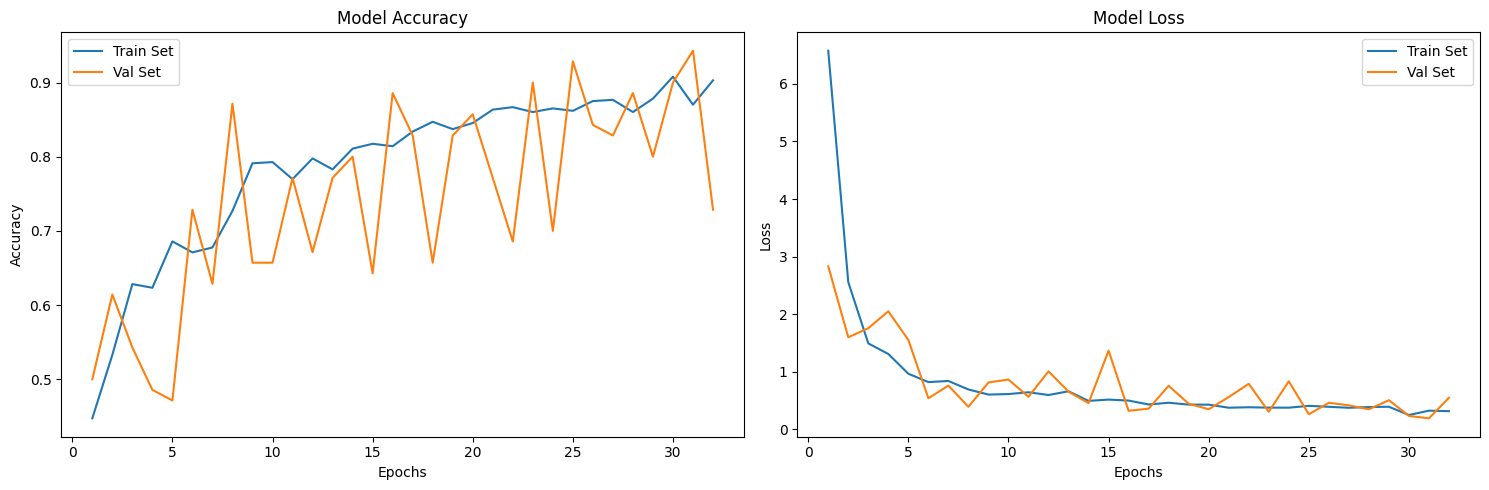

In [ ]:
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract features using InceptionV3
train_features_incep = model.predict(train_data)
val_features_incep = model.predict(val_data)
test_features_incep = model.predict(test_data)

# Flatten the features
train_features_flat = train_features_incep.reshape(train_features_incep.shape[0], -1)
val_features_flat = val_features_incep.reshape(val_features_incep.shape[0], -1)
test_features_flat = test_features_incep.reshape(test_features_incep.shape[0], -1)

# SVM
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(train_features_flat, train_data.classes)
svm_predictions = svm_classifier.predict(test_features_flat)

svm_accuracy = accuracy_score(test_data.classes, svm_predictions)
svm_precision = precision_score(test_data.classes, svm_predictions, average='weighted')
svm_recall = recall_score(test_data.classes, svm_predictions, average='weighted')
svm_f1_score = f1_score(test_data.classes, svm_predictions, average='weighted')

print("SVM Metrics:")
print(f"Accuracy: {svm_accuracy*100:.2f}%")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1 Score: {svm_f1_score:.2f}")

# Logistic Regression
logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_classifier.fit(train_features_flat, train_data.classes)
logistic_predictions = logistic_classifier.predict(test_features_flat)

logistic_accuracy = accuracy_score(test_data.classes, logistic_predictions)
logistic_precision = precision_score(test_data.classes, logistic_predictions, average='weighted')
logistic_recall = recall_score(test_data.classes, logistic_predictions, average='weighted')
logistic_f1_score = f1_score(test_data.classes, logistic_predictions, average='weighted')

print("\nLogistic Regression Metrics:")
print(f"Accuracy: {logistic_accuracy*100:.2f}%")
print(f"Precision: {logistic_precision:.2f}")
print(f"Recall: {logistic_recall:.2f}")
print(f"F1 Score: {logistic_f1_score:.2f}")

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_flat, train_data.classes)
rf_predictions = rf_classifier.predict(test_features_flat)

rf_accuracy = accuracy_score(test_data.classes, rf_predictions)
rf_precision = precision_score(test_data.classes, rf_predictions, average='weighted')
rf_recall = recall_score(test_data.classes, rf_predictions, average='weighted')
rf_f1_score = f1_score(test_data.classes, rf_predictions, average='weighted')

print("\nRandom Forest Classifier Metrics:")
print(f"Accuracy: {rf_accuracy*100:.2f}%")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"F1 Score: {rf_f1_score:.2f}")

63/63 [==============================] - 99s 2s/step
SVM Metrics:
Accuracy: 38.10%
Precision: 0.15
Recall: 0.38
F1 Score: 0.21

Logistic Regression Metrics:
Accuracy: 35.87%
Precision: 0.21
Recall: 0.36
F1 Score: 0.22

Random Forest Classifier Metrics:
Accuracy: 23.81%
Precision: 0.24
Recall: 0.24
F1 Score: 0.24


In [ ]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    img = image.load_img(path, target_size=(350,350))
    norm_img = image.img_to_array(img)/255
    input_arr_img = np.array([norm_img])
    pred = np.argmax(_model.predict(input_arr_img))
    print(classes_dir[pred])

In [ ]:
path = '/content/drive/MyDrive/Data/test/adenocarcinoma/000128 (5).png'
chestScanPrediction(path,model)

1/1 [==============================] - 5s 5s/step
Adenocarcinoma


In [ ]:
path = '/content/drive/MyDrive/Data/test/normal/normal.png'
chestScanPrediction(path,model)

1/1 [==============================] - 1s 556ms/step
Normal


In [ ]:
path = '/content/drive/MyDrive/Data/test/large.cell.carcinoma/000111.png'
chestScanPrediction(path,model)

1/1 [==============================] - 1s 529ms/step
Large cell carcinoma
